In [1]:
from __future__ import print_function
import zipfile
import os

import argparse
from tqdm import tqdm
import os
import PIL.Image as Image

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import copy

import easydict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')

Using device: cuda

GeForce GTX 1070
Memory Usage:
Allocated: 0.0 MB
Cached:    0.0 MB


In [3]:
def initialize_data(folder):
    train_zip = folder + '/train_images.zip'
    test_zip = folder + '/test_images.zip'
    if not os.path.exists(train_zip) or not os.path.exists(test_zip):
        raise(RuntimeError("Could not find " + train_zip + " and " + test_zip
              + ', please download them from https://www.kaggle.com/c/nyu-cv-fall-2018/data '))
    # extract train_data.zip to train_data
    train_folder = folder + '/train_images'
    if not os.path.isdir(train_folder):
        print(train_folder + ' not found, extracting ' + train_zip)
        zip_ref = zipfile.ZipFile(train_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()
    # extract test_data.zip to test_data
    test_folder = folder + '/test_images'
    if not os.path.isdir(test_folder):
        print(test_folder + ' not found, extracting ' + test_zip)
        zip_ref = zipfile.ZipFile(test_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()

    # make validation_data by using images 00000*, 00001* and 00002* in each class
    val_folder = folder + '/val_images'
    if not os.path.isdir(val_folder):
        print(val_folder + ' not found, making a validation set')
        os.mkdir(val_folder)
        for dirs in os.listdir(train_folder):
            if dirs.startswith('000'):
                os.mkdir(val_folder + '/' + dirs)
                for f in os.listdir(train_folder + '/' + dirs):
                    if f.startswith('00000') or f.startswith('00001') or f.startswith('00002'):
                        # move file to validation folder
                        os.rename(train_folder + '/' + dirs + '/' + f, val_folder + '/' + dirs + '/' + f)

In [4]:
address = 'C:/Users/tiany/Assignment_2'
initialize_data(address)

data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

args = easydict.EasyDict({
    'batch_size': 64,
    'epochs':100,
    'lr':0.00005,
    'momentum':0.5,
    'seed':1,
    'log_interval':100,
    'weight_decay':1e-2
})

kwargs = {'num_workers': 12, 'pin_memory': True}

torch.manual_seed(args.seed)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(address + '/train_images',
                         transform=data_transforms),
    batch_size=args.batch_size, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(address + '/val_images',
                         transform=data_transforms),
    batch_size=args.batch_size, shuffle=False, **kwargs)

In [7]:
class Inception(nn.Module):
    """ Reference:
    GoogLeNet: 
    Going Deeper with Convolutions
    https://arxiv.org/abs/1409.4842v1
    Github Reference: https://github.com/xuchaoxi/pytorch-classification/blob/master/models/googlenet.py
    """
    def __init__(self, in_channels, _1x1_, _3x3reduce_, _3x3_, _5x5reduce_, _5x5_, pool_proj):
        super(Inception, self).__init__()
        self.con1x1 = nn.Sequential(
            nn.Conv2d(in_channels, _1x1_, kernel_size=1),
            nn.BatchNorm2d(_1x1_),
            nn.ReLU(True),
        )
        self.con1x1_3x3 = nn.Sequential(
            nn.Conv2d(in_channels, _3x3reduce_, kernel_size=1),
            nn.BatchNorm2d(_3x3reduce_),
            nn.ReLU(True),
            nn.Conv2d(_3x3reduce_, _3x3_, kernel_size=3, padding=1),
            nn.BatchNorm2d(_3x3_),
            nn.ReLU(True),
            #nn.Conv2d(_3x3_, _3x3_, kernel_size=3, padding=1),
            #nn.BatchNorm2d(_3x3_),
            #nn.ReLU(True),
        )
        self.con1x1_5x5 = nn.Sequential(
            nn.Conv2d(in_channels, _5x5reduce_, kernel_size=1),
            nn.BatchNorm2d(_5x5reduce_),
            nn.ReLU(True),
            nn.Conv2d(_5x5reduce_, _5x5_, kernel_size=3, padding=1),
            nn.BatchNorm2d(_5x5_),
            nn.ReLU(True),
            nn.Conv2d(_5x5_, _5x5_, kernel_size=3, padding=1),
            nn.BatchNorm2d(_5x5_),
            nn.ReLU(True),
        )
        self.mp3x3_con1x1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, pool_proj, kernel_size = 1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True),
        )
    def forward(self, inputs):
        output_con1x1 = self.con1x1(inputs)
        output_con1x1_3x3 = self.con1x1_3x3(inputs)
        output_con1x1_5x5 = self.con1x1_5x5(inputs)
        output_mp3x3_con1x1 = self.mp3x3_con1x1(inputs)
        output = torch.cat([output_con1x1,output_con1x1_3x3,output_con1x1_5x5,output_mp3x3_con1x1], dim=1)
        return output


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self._3a = Inception(192,  64,  96, 128, 16, 32, 32)
        self._3b = Inception(256, 128, 128, 192, 32, 96, 64)

        self._4a = Inception(480, 192,  96, 208, 16,  48,  64)
        self._4b = Inception(512, 160, 112, 224, 24,  64,  64)
        self._4c = Inception(512, 128, 128, 256, 24,  64,  64)
        self._4d = Inception(512, 112, 144, 288, 32,  64,  64)
        self._4e = Inception(528, 256, 160, 320, 32, 128, 128)

        self._5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self._5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.dropout = nn.Dropout2d(0.4)
        self.linear = nn.Linear(1024, 43)
    def forward(self, input):
        output_pl = self.pre_layers(input)
        output_3a = self._3a(output_pl)
        output_3b = self._3b(output_3a)
        output_mp1 = self.maxpool(output_3b)
        output_4a = self._4a(output_mp1)
        output_4b = self._4b(output_4a)
        output_4c = self._4c(output_4b)
        output_4d = self._4d(output_4c)
        output_4e = self._4e(output_4d)
        output_mp2 = self.maxpool(output_4e)
        output_5a = self._5a(output_mp2)
        output_5b = self._5b(output_5a)
        output_ap = self.avgpool(output_5b)
        output_drop = self.dropout(output_ap)
        output_ = output_drop.view(output_drop.size(0), -1)
        output_ = self.linear(output_)
        return output_

In [8]:
### Neural Network and Optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
model = GoogLeNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr,weight_decay=args.weight_decay)

In [9]:
def train(epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        train_loss = F.cross_entropy(output,target).to(device)
        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        training_accuracy = 100. * correct / len(train_loader.dataset)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}/{} ({:.6f}%)'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item(),
                correct, len(train_loader.dataset), training_accuracy))

    return train_loss.item(), training_accuracy
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        validation_loss += F.cross_entropy(output,target).to(device).item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(val_loader.dataset)
    validation_accuracy = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset), validation_accuracy))
    return validation_loss, validation_accuracy

In [8]:
training_loss_log = []
training_accuracy_log = []
validation_loss_log = []
validation_accuracy_log = []
best_acc = 0.0


for epoch in range(1, args.epochs + 1):
    training_loss, training_accuracy = train(epoch)
    validation_loss, validation_accuracy = validation() 
    
    training_loss_log.append(training_loss)
    training_accuracy_log.append(training_accuracy)
    validation_loss_log.append(validation_loss)
    validation_accuracy_log.append(validation_accuracy)
    
    if validation_accuracy > best_acc:
        best_acc = validation_accuracy
        torch.save(model.state_dict(), "model_GoogLeNet_3_best.pth")
        
    torch.save(model.state_dict(), "model_GoogLeNet_3_" + str(epoch) + ".pth")

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.816276	Accuracy: 3/35339 (0.008489%)
Train Epoch: 1 [6400/35339 (18%)]	Loss: 2.399459	Accuracy: 1129/35339 (3.194771%)
Train Epoch: 1 [12800/35339 (36%)]	Loss: 2.320369	Accuracy: 3582/35339 (10.136110%)
Train Epoch: 1 [19200/35339 (54%)]	Loss: 1.334304	Accuracy: 6961/35339 (19.697784%)
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.818861	Accuracy: 11164/35339 (31.591160%)
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.517099	Accuracy: 16101/35339 (45.561561%)

Validation set: Average loss: 0.031362, Accuracy: 1696/3870 (43.824289%)

Train Epoch: 2 [0/35339 (0%)]	Loss: 0.621253	Accuracy: 53/35339 (0.149976%)
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.386763	Accuracy: 5723/35339 (16.194573%)
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.276019	Accuracy: 11605/35339 (32.839073%)
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.142109	Accuracy: 17663/35339 (49.981607%)
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.144317	Accuracy: 23854/35339 (67.500495%)
Train Epoch: 2 [

Train Epoch: 29 [6400/35339 (18%)]	Loss: 0.000105	Accuracy: 6464/35339 (18.291406%)
Train Epoch: 29 [12800/35339 (36%)]	Loss: 0.000065	Accuracy: 12864/35339 (36.401709%)
Train Epoch: 29 [19200/35339 (54%)]	Loss: 0.000075	Accuracy: 19264/35339 (54.512012%)
Train Epoch: 29 [25600/35339 (72%)]	Loss: 0.000348	Accuracy: 25664/35339 (72.622315%)
Train Epoch: 29 [32000/35339 (90%)]	Loss: 0.000098	Accuracy: 32064/35339 (90.732618%)

Validation set: Average loss: 0.001211, Accuracy: 3776/3870 (97.571059%)

Train Epoch: 30 [0/35339 (0%)]	Loss: 0.000085	Accuracy: 64/35339 (0.181103%)
Train Epoch: 30 [6400/35339 (18%)]	Loss: 0.000128	Accuracy: 6464/35339 (18.291406%)
Train Epoch: 30 [12800/35339 (36%)]	Loss: 0.000063	Accuracy: 12864/35339 (36.401709%)
Train Epoch: 30 [19200/35339 (54%)]	Loss: 0.000088	Accuracy: 19264/35339 (54.512012%)
Train Epoch: 30 [25600/35339 (72%)]	Loss: 0.000085	Accuracy: 25664/35339 (72.622315%)
Train Epoch: 30 [32000/35339 (90%)]	Loss: 0.000066	Accuracy: 32064/35339 (90.7

Train Epoch: 57 [6400/35339 (18%)]	Loss: 0.001628	Accuracy: 6456/35339 (18.268768%)
Train Epoch: 57 [12800/35339 (36%)]	Loss: 0.004227	Accuracy: 12849/35339 (36.359263%)
Train Epoch: 57 [19200/35339 (54%)]	Loss: 0.000263	Accuracy: 19241/35339 (54.446928%)
Train Epoch: 57 [25600/35339 (72%)]	Loss: 0.000305	Accuracy: 25632/35339 (72.531764%)
Train Epoch: 57 [32000/35339 (90%)]	Loss: 0.000056	Accuracy: 32032/35339 (90.642067%)

Validation set: Average loss: 0.001638, Accuracy: 3745/3870 (96.770026%)

Train Epoch: 58 [0/35339 (0%)]	Loss: 0.000101	Accuracy: 64/35339 (0.181103%)
Train Epoch: 58 [6400/35339 (18%)]	Loss: 0.000621	Accuracy: 6464/35339 (18.291406%)
Train Epoch: 58 [12800/35339 (36%)]	Loss: 0.000044	Accuracy: 12864/35339 (36.401709%)
Train Epoch: 58 [19200/35339 (54%)]	Loss: 0.000054	Accuracy: 19264/35339 (54.512012%)
Train Epoch: 58 [25600/35339 (72%)]	Loss: 0.000199	Accuracy: 25664/35339 (72.622315%)
Train Epoch: 58 [32000/35339 (90%)]	Loss: 0.000035	Accuracy: 32064/35339 (90.7

Train Epoch: 85 [6400/35339 (18%)]	Loss: 0.000005	Accuracy: 6464/35339 (18.291406%)
Train Epoch: 85 [12800/35339 (36%)]	Loss: 0.000004	Accuracy: 12864/35339 (36.401709%)
Train Epoch: 85 [19200/35339 (54%)]	Loss: 0.000007	Accuracy: 19264/35339 (54.512012%)
Train Epoch: 85 [25600/35339 (72%)]	Loss: 0.000002	Accuracy: 25664/35339 (72.622315%)
Train Epoch: 85 [32000/35339 (90%)]	Loss: 0.000010	Accuracy: 32064/35339 (90.732618%)

Validation set: Average loss: 0.000333, Accuracy: 3840/3870 (99.224806%)

Train Epoch: 86 [0/35339 (0%)]	Loss: 0.000002	Accuracy: 64/35339 (0.181103%)
Train Epoch: 86 [6400/35339 (18%)]	Loss: 0.000004	Accuracy: 6464/35339 (18.291406%)
Train Epoch: 86 [12800/35339 (36%)]	Loss: 0.000001	Accuracy: 12864/35339 (36.401709%)
Train Epoch: 86 [19200/35339 (54%)]	Loss: 0.000014	Accuracy: 19264/35339 (54.512012%)
Train Epoch: 86 [25600/35339 (72%)]	Loss: 0.000002	Accuracy: 25664/35339 (72.622315%)
Train Epoch: 86 [32000/35339 (90%)]	Loss: 0.000002	Accuracy: 32064/35339 (90.7

In [41]:
training_loss_log

[0.7758997082710266,
 0.7438040375709534,
 0.3006015121936798,
 0.019883979111909866,
 0.051150497049093246,
 0.007298296317458153,
 0.01303295698016882,
 0.0095942672342062,
 0.003629250917583704,
 0.028092600405216217,
 0.045554205775260925,
 0.05541370064020157,
 0.017157120630145073,
 0.02184009552001953,
 0.0044038076885044575,
 0.007422273978590965,
 0.005271218251436949,
 0.20837408304214478,
 0.002623211359605193,
 0.008907231502234936,
 0.0013577287318184972,
 0.0003293644404038787,
 0.00014409152208827436,
 0.0005191456293687224,
 0.09055330604314804,
 0.06791318207979202,
 0.00047410617116838694,
 0.0007597749936394393,
 0.00044085763511247933,
 0.0005323670338839293,
 0.00024682824732735753,
 0.0008065483998507261,
 0.0008958036196418107,
 0.001573996152728796,
 0.0009664622484706342,
 0.041456807404756546,
 0.0033456196542829275,
 0.04245125129818916,
 0.06636012345552444,
 0.0005007656873203814,
 6.667050183750689e-05,
 0.00025064294459298253,
 0.00041515176417306066,
 0.

In [40]:
training_accuracy_log

[53.24429100993237,
 94.13678938283483,
 99.18220662723903,
 99.68023996151561,
 99.59534791590028,
 99.69721837063867,
 99.62930473414642,
 99.92642689380006,
 99.70287784034636,
 99.83870511333087,
 99.85851325730779,
 99.75947253742325,
 99.92642689380006,
 99.84719431789242,
 99.84719431789242,
 99.90661874982314,
 99.9801918560231,
 99.73966439344633,
 99.90095928011546,
 99.94623503777696,
 100.0,
 100.0,
 100.0,
 100.0,
 99.96604318175388,
 99.55290189309262,
 99.94057556806928,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.70853731005404,
 99.95189450748465,
 99.98868106058463,
 99.95189450748465,
 99.91227821953083,
 99.94057556806928,
 99.9745323863154,
 99.92642689380006,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.73966439344633,
 99.96887291660771,
 100.0,
 100.0,
 99.93774583321543,
 99.95472424233849,
 100.0,
 99.90378901496929,
 100.0,
 100.0,
 99.99717026514615,
 99.87266193157701,
 99.95472424233849,
 99.99717026514615,
 99.98302159087693

In [42]:
validation_loss_log

[0.031362368054784234,
 0.016077750099182744,
 0.011899812321253218,
 0.011648462294030559,
 0.007816475255592925,
 0.007096856673674066,
 0.009678067589655172,
 0.014394358690895467,
 0.0069546880423108194,
 0.005681304571288578,
 0.014072122039316699,
 0.0054962195137164315,
 0.005045811501054878,
 0.004447347730475186,
 0.004632666895078201,
 0.0037251972299922275,
 0.0023219855077741746,
 0.0020322950762876,
 0.0042363460669931725,
 0.0016423151209572623,
 0.001567839367588313,
 0.0015682862313996426,
 0.0013405586705320196,
 0.0014563402939097203,
 0.013892877893161404,
 0.0014622478038662182,
 0.0012431925311237899,
 0.0013219611118899571,
 0.0012110806751312827,
 0.0012547961412626304,
 0.001226489467804518,
 0.0011184352992822542,
 0.0039481504115177375,
 0.0017812561961215768,
 0.001812269038807129,
 0.0025248550019378578,
 0.002738489514308228,
 0.0016355721318483045,
 0.0016127076627249234,
 0.0019749801637385586,
 0.0017717044042626492,
 0.001546361550021461,
 0.00152980506

In [38]:
validation_accuracy_log

[43.82428940568475,
 70.82687338501292,
 80.10335917312662,
 77.51937984496124,
 86.66666666666667,
 87.59689922480621,
 85.11627906976744,
 78.63049095607235,
 88.29457364341086,
 90.95607235142118,
 75.16795865633075,
 90.46511627906976,
 92.37726098191214,
 93.17829457364341,
 91.44702842377261,
 94.1343669250646,
 95.81395348837209,
 96.22739018087856,
 92.7390180878553,
 97.05426356589147,
 97.1576227390181,
 97.05426356589147,
 97.46770025839793,
 97.33850129198966,
 80.90439276485787,
 97.18346253229974,
 97.67441860465117,
 97.49354005167959,
 97.57105943152455,
 97.67441860465117,
 97.62273901808786,
 98.01033591731266,
 94.34108527131782,
 96.95090439276485,
 96.89922480620154,
 95.76227390180878,
 95.76227390180878,
 97.1576227390181,
 97.02842377260981,
 96.56330749354005,
 96.4857881136951,
 97.10594315245478,
 97.05426356589147,
 96.66666666666667,
 97.00258397932816,
 97.10594315245478,
 97.23514211886305,
 97.59689922480621,
 97.13178294573643,
 98.19121447028424,
 97.4

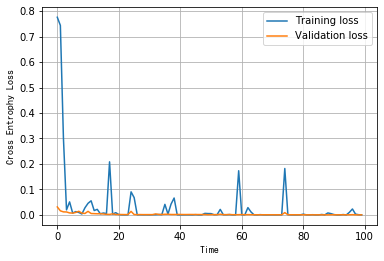

In [12]:
import matplotlib.pyplot as plt
time = list(range(100))
%matplotlib inline
plt.plot(time,train_loss_log)
plt.plot(time,validation_loss_log)
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.ylabel(u'Cross Entrophy Loss',fontproperties='SimHei')
plt.xlabel(u'Time',fontproperties='SimHei')

plt.grid(True)
plt.show()

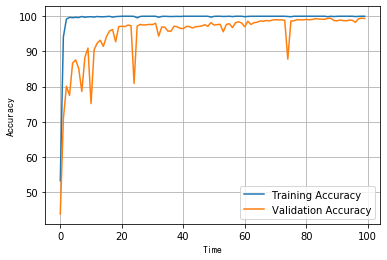

In [13]:
import matplotlib.pyplot as plt
time = list(range(100))
%matplotlib inline
plt.plot(time,training_accuracy_log)
plt.plot(time,validation_accuracy_log)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylabel(u'Accuracy',fontproperties='SimHei')
plt.xlabel(u'Time',fontproperties='SimHei')

plt.grid(True)
plt.show()